## 1. Definitions

Cars are onsite only between 10AM and 12AM.

$i$: Index for each 15 min chunk of a day. There are 96 chunks of 15 min in a day. So, i goes from 0 to 95.

$t_i$: time interval for a given chunk of the day, which is 15 min = 1/4 hr.

$j$: Car index.

$P_{i,j}$: Power used from any charger at a given 15 min chunk (kW).

$Trf_i$: Customer's electricity tariff at a given 15 min chunk ($/kWh).

$BL_i$: Buildingload at a given 15 min chunk (kW). 

$Eff_{j}$: Charging efficiency of the car.

$B$: Battery capacity of a car (kWh).

$E_{j}$: Energy required for a given car (kWh).


## 2. Equations
The optimization problem can be formulated with following equations and inequalities.

$$ min \left( Bill = \sum_{i=0}^{95} \sum_{j=0}^{3} (P_{i,j} + BL_i) . Trf_i . t_i + max(\sum_{j=0}^{3} P_{i,j} + BL_i) . 16 \right) $$

$$S.T.$$

$$ 0 < P_{i,j} < 7 $$

$$Trf_i = 
\begin{cases}
  0.4   & if & 9AM < time < 4PM \\
  0.1   & otherwise       \\
\end{cases}
$$

$$
Eff_{i, j} =
\begin{cases}
  0.7 & if & P_i \leq 5 \\
  0.9 & if & P_i >5 \\
\end{cases}
$$

$$E_{j} = \sum_{i=0}^{55} P_{i, j} . Eff_{i, j} = U(15, 35)_{j} - 5$$

$$E_{j} <  B_{j} = 40$$

Note: The time range in the customer's tariff 9AM < time < 4PM translates to 36 < i < 64 index range.

## 2. Solution

This challenge is a multivariate linear programming problem, where the cost function (total bill) is a scalar. The decision variable is the power used at every 15 minutes from each of the 4 chargers. One day consists of 96 chunks of 15 mins, which translates to a 96 x 4 = 384 variables for 4 chargers/cars.

In this section, I present my solution to the optimization problem. I use scipy.optimize to solve the problem using the equations above.

In [1]:
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt

%config InlineBackend.figure_formats = ['svg']

In [2]:
NCARS = 4  # Number of cars.
PMIN = 0  # Chargers' lower bound.
PMAX = 7  # Chargers' upper bound.

TRF_I1 = 36  # Index 1 that corresponds to 4 AM in the tariff definition.
TRF_I2 = 64  # Index 2 that corresponds to 4 AM in the tariff definition.

E_CAR_L = 25  # Lower limit for the vehicle's energy when departing.
E_CAR_U = 35  # Upper limit for the vehicle's energy when departing.

B_LEFT = 5  # Energy left in the car's battery.

# Building load
def read_buildingload():
    df = pd.read_csv('data/buildingload.csv')
    df['Timestamp'] = pd.to_datetime(df.Timestamp)
    return df

buildingload = read_buildingload()
bl = buildingload['BuildingLoad[kW]'].values
bl = np.tile(bl, NCARS)
time = buildingload['Timestamp']


# Customer's tariff
def customer_trf():
    trf = np.full(96, 0.1)  # Condition 1
    trf[TRF_I1:TRF_I2] = 0.4  # Condition 2
    return trf # np.tile(trf, NCARS)

trf = customer_trf()


# Car's efficiency
def eff(p):
    return np.where(p < 5, 0.7, 0.9)

# Objective function
def bill(p):
    expr1 = (p+bl).reshape(-1,96).sum(0)
    bill = (expr1 * trf/4.).sum() + max(expr1) * 16.  # 1/4  15min/60min = 1/4 
    return bill


# Initial guess
p = np.random.uniform(PMIN, PMAX, NCARS * 96)

# Generate energies required by NCARS number of cars.
np.random.seed(42)
pcar = np.random.uniform(E_CAR_L, E_CAR_U, NCARS) - B_LEFT

# Constraints
cons1 = {'type': 'eq', 'fun': lambda x: np.sum(x[0:96]*eff(x[0:96])) - pcar[0]}
cons2 = {'type': 'eq', 'fun': lambda x: np.sum(x[96:192]*eff(x[96:192])) - pcar[1]}
cons3 = {'type': 'eq', 'fun': lambda x: np.sum(x[192:288]*eff(x[192:288])) - pcar[2]}
cons4 = {'type': 'eq', 'fun': lambda x: np.sum(x[288:384]*eff(x[288:384])) - pcar[3]}

# Bounds
bounds = (((0, 1e-12),) * 40 + ((PMIN, PMAX),) * 56) * NCARS  # In the first 40 chunks of the time, cars are not charged as they travel.

In [3]:
# Optimize
res = optimize.minimize(bill, x0=p, bounds=bounds, constraints=[cons1, cons2, cons3, cons4])
print(res['message'])
print(f'Bill: $%f' % res['fun'])

Optimization terminated successfully
Bill: $2080.156534


## 3. Results and Consistency Check

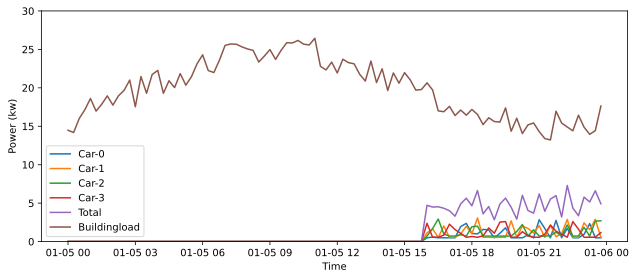

In [4]:
plt.figure(figsize=(9, 4))
for i in range(NCARS):
    label = 'Car-' + str(i)
    plt.plot(time, res.x[i * 96: (i + 1) * 96], label=label)
plt.plot(time, res.x.reshape(-1, 96).sum(0), label='Total')
plt.plot(time, bl[:96], label='Buildingload')
#plt.vline(40)
plt.xlabel('Time')
plt.ylabel('Power (kw)')
plt.ylim(0, 30)
plt.legend(loc=0)
plt.tight_layout()
plt.show()

In [5]:
print('Cost due to buildingload: $%f, which is smaller than the total bill.' % bill(np.zeros(96 * NCARS)))

Cost due to buildingload: $2076.350853, which is smaller than the total bill.


In [6]:
print('Energy Required for each car:', pcar)

Energy Required for each car: [23.74540119 29.50714306 27.31993942 25.98658484]


In [7]:
print('Energy used to charge each car: ', res.x.reshape(-1, 96).sum(1))
print("Note that the cars are not charged with 100% efficiency! That's why energy used is bigger than the energy required.")

Energy used to charge each car:  [33.9220017  42.15306152 39.02848488 37.12369263]
Note that the cars are not charged with 100% efficiency! That's why energy used is bigger than the energy required.


In [8]:
print('Everything looks good when the efficiency is taken into account:',(res.x.reshape(-1, 96)*eff(res.x.reshape(-1, 96))).sum(-1))

Everything looks good when the efficiency is taken into account: [23.74540119 29.50714307 27.31993942 25.98658484]
